# Import packages

In [1]:
import csv, sqlite3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Read all csv files and check data

In [2]:
malaria_deaths = pd.read_csv('malaria_deaths.csv')
malaria_deaths_age = pd.read_csv('malaria_deaths_age.csv')
malaria_inc = pd.read_csv('malaria_inc.csv')



In [3]:
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

print( malaria_deaths.head())
print('\n', malaria_deaths_age.head())
print('\n', malaria_inc.head())

     Entity    Code  Year  Deaths - Malaria - Sex: Both - Age: Age-standardized (Rate) (per 100,000 people)
0  Afghanistan  AFG  1990                        6.803                                                     
1  Afghanistan  AFG  1991                        6.973                                                     
2  Afghanistan  AFG  1992                        6.990                                                     
3  Afghanistan  AFG  1993                        7.089                                                     
4  Afghanistan  AFG  1994                        7.392                                                     

    Unnamed: 0    entity    code  year age_group  deaths 
0       1      Afghanistan  AFG  1990   Under 5  184.606
1       2      Afghanistan  AFG  1991   Under 5  191.658
2       3      Afghanistan  AFG  1992   Under 5  197.140
3       4      Afghanistan  AFG  1993   Under 5  207.358
4       5      Afghanistan  AFG  1994   Under 5  226.209

      E

# Merge files to create different tables to add into sqlite

In [4]:
# Merge all files to obtain a list of common entity and code
malaria_combined=pd.merge(malaria_deaths, malaria_deaths_age, left_on=['Entity', 'Code', 'Year'],right_on=['entity','code','year'], how = 'outer')
malaria_combined.drop(columns=['entity','code','year'], inplace = True)
malaria_combined=pd.merge(malaria_combined, malaria_inc, on=['Entity', 'Code', 'Year'], how = 'outer', indicator = True)

entities = malaria_combined.drop_duplicates(subset = ['Entity', 'Code'])[['Entity', 'Code']].reset_index().drop(columns=['index'])
entities = entities.reset_index()
entities.rename(columns={'index': 'id'}, inplace = True)

In [5]:
# Remove entity and code from datasets and add an 'id' column

malaria_deaths = pd.merge(malaria_deaths, entities, on = ['Entity', 'Code'], how = 'left')
malaria_deaths_age = pd.merge(malaria_deaths_age, entities, left_on = ['entity', 'code'], right_on = ['Entity', 'Code'], how = 'left')
malaria_inc = pd.merge(malaria_inc, entities, on = ['Entity', 'Code'], how = 'left')

malaria_deaths.drop(columns=['Entity','Code'], inplace = True)
malaria_deaths_age.drop(columns=['entity','code', 'Entity','Code'], inplace = True)
malaria_inc.drop(columns=['Entity', 'Code'], inplace = True)

In [6]:
entities

,id,Entity,Code
0,0,Afghanistan,AFG
1,1,Albania,ALB
2,2,Algeria,DZA
3,3,American Samoa,ASM
4,4,Andean Latin America,NaN
...,...,...,...
248,248,Pre-demographic dividend,NaN
249,249,South Asia (IDA & IBRD),NaN
250,250,Sub-Saharan Africa (IDA & IBRD),NaN
251,251,Sub-Saharan Africa (excluding high income),NaN


In [7]:
# Rename long column names
malaria_deaths.rename(columns={ malaria_deaths.columns[1]: "Deaths_per_100k" }, inplace = True)
malaria_inc.rename(columns={ malaria_inc.columns[1]: "Incidence_per_1k" }, inplace = True)

# Start SQLite3

In [8]:
# Start SQLite3
con = sqlite3.connect(":memory:")
cur = con.cursor()

In [9]:
entities.to_sql(name='entities', con=con, if_exists='replace', dtype={'id': 'INTEGER PRIMARY KEY'})
malaria_deaths.to_sql(name='malaria_deaths', con=con, if_exists='replace')
malaria_deaths_age.to_sql(name='malaria_deaths_age', con=con, if_exists='replace')
malaria_inc.to_sql(name='malaria_inc', con=con, if_exists='replace')

C:\Users\jun_y\anaconda3\lib\site-packages\pandas\core\generic.py:2872: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [10]:
# Check entity table
cur.execute('select * from entities;')
cur.fetchall()


[(0, 0, 'Afghanistan', 'AFG'),
 (1, 1, 'Albania', 'ALB'),
 (2, 2, 'Algeria', 'DZA'),
 (3, 3, 'American Samoa', 'ASM'),
 (4, 4, 'Andean Latin America', None),
 (5, 5, 'Andorra', 'AND'),
 (6, 6, 'Angola', 'AGO'),
 (7, 7, 'Antigua and Barbuda', 'ATG'),
 (8, 8, 'Argentina', 'ARG'),
 (9, 9, 'Armenia', 'ARM'),
 (10, 10, 'Australasia', None),
 (11, 11, 'Australia', 'AUS'),
 (12, 12, 'Austria', 'AUT'),
 (13, 13, 'Azerbaijan', 'AZE'),
 (14, 14, 'Bahamas', 'BHS'),
 (15, 15, 'Bahrain', 'BHR'),
 (16, 16, 'Bangladesh', 'BGD'),
 (17, 17, 'Barbados', 'BRB'),
 (18, 18, 'Belarus', 'BLR'),
 (19, 19, 'Belgium', 'BEL'),
 (20, 20, 'Belize', 'BLZ'),
 (21, 21, 'Benin', 'BEN'),
 (22, 22, 'Bermuda', 'BMU'),
 (23, 23, 'Bhutan', 'BTN'),
 (24, 24, 'Bolivia', 'BOL'),
 (25, 25, 'Bosnia and Herzegovina', 'BIH'),
 (26, 26, 'Botswana', 'BWA'),
 (27, 27, 'Brazil', 'BRA'),
 (28, 28, 'Brunei', 'BRN'),
 (29, 29, 'Bulgaria', 'BGR'),
 (30, 30, 'Burkina Faso', 'BFA'),
 (31, 31, 'Burundi', 'BDI'),
 (32, 32, 'Cambodia', 'KHM')

# Visualizations

In [12]:
# Query 1 and visualization 1
query_1 = ('''select entity, year, Deaths_per_100k 
    from malaria_deaths 
    left join (select entities.id, entity 
        from entities 
        join malaria_deaths 
        on malaria_deaths.id = entities.id 
        group by entity
        order by avg(Deaths_per_100k) desc
        limit 10) as high_death
    on malaria_deaths.id = high_death.id 
    where entity is not Null;''' )
output_1 = pd.read_sql(query_1, con)
output_1

,entity,Year,Deaths_per_100k
0,Burkina Faso,1990,148.890
1,Burkina Faso,1991,154.471
2,Burkina Faso,1992,158.052
3,Burkina Faso,1993,162.043
4,Burkina Faso,1994,164.069
...,...,...,...
265,Uganda,2012,69.818
266,Uganda,2013,54.161
267,Uganda,2014,48.320
268,Uganda,2015,50.672


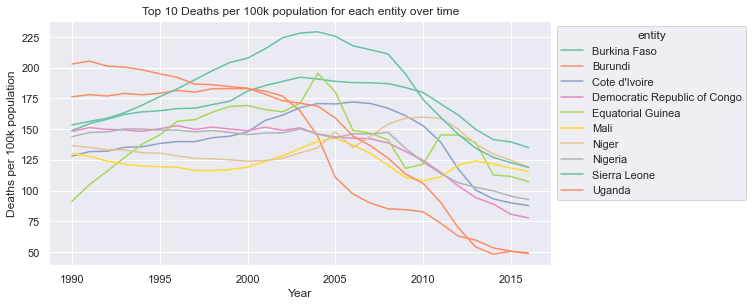

In [13]:
sns.set(rc={'figure.figsize':(9,4.5)})

p = sns.lineplot(
    data=output_1, x="Year", y = 'Deaths_per_100k', hue = 'entity', palette = 'Set2'
    
    
)
p.set(title = 'Top 10 Deaths per 100k population for each entity over time', ylabel= 'Deaths per 100k population' , 
      xlabel='Year')
sns.move_legend(p, "upper left", bbox_to_anchor=(1, 1))

In [14]:
# Query 2 and visualization 2
query_2 = ('''select age_group, sum(deaths) total_deaths
    from malaria_deaths_age 
    join entities
    on malaria_deaths_age.id = entities.id 
    group by age_group;''' )
output_2 = pd.read_sql(query_2, con)
output_2

,age_group,total_deaths
0,15-49,8.463e+06
1,5-14,1.027e+07
2,50-69,4.840e+06
3,70 or older,3.003e+06
4,Under 5,8.727e+07


[Text(0.5, 1.0, 'Top 10 Deaths per 100k population for each entity over time'),
 Text(0, 0.5, 'Deaths'),
 Text(0.5, 0, 'Year')]

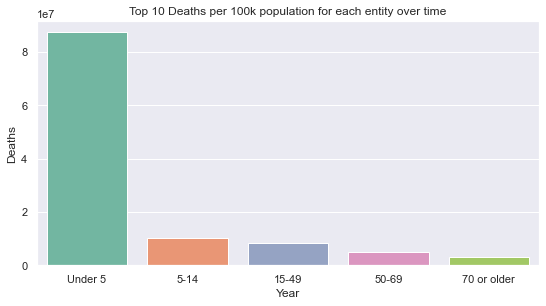

In [15]:
sns.set(rc={'figure.figsize':(9,4.5)})

p = sns.barplot(
    data=output_2, x="age_group", y = 'total_deaths', palette = 'Set2', order = ['Under 5', '5-14', '15-49', '50-69', '70 or older']
    
    
)
p.set(title = 'Top 10 Deaths per 100k population for each entity over time', ylabel= 'Deaths' , 
      xlabel='Year')


In [16]:
# Query 3 and visualization 3
query_3 = ('''select entity, year, Incidence_per_1k 
    from malaria_inc 
    left join (select entities.id, entity 
        from entities 
        join malaria_inc 
        on malaria_inc.id = entities.id 
        group by entity
        order by avg(Incidence_per_1k) desc
        limit 10) as high_inc
    on malaria_inc.id = high_inc.id 
    where entity is not Null;''' )
output_3 = pd.read_sql(query_3, con)
output_3

,entity,Year,Incidence_per_1k
0,Burkina Faso,2000,621.6
1,Burkina Faso,2005,549.8
2,Burkina Faso,2010,601.4
3,Burkina Faso,2015,389.2
4,Cote d'Ivoire,2000,525.4
5,Cote d'Ivoire,2005,530.9
6,Cote d'Ivoire,2010,446.2
7,Cote d'Ivoire,2015,348.8
8,Democratic Republic of Congo,2000,508.5
9,Democratic Republic of Congo,2005,524.9


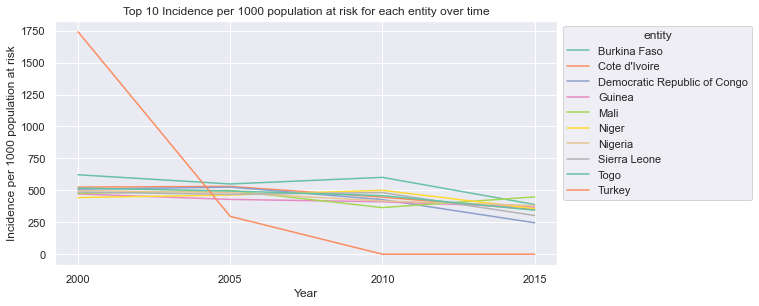

In [17]:
sns.set(rc={'figure.figsize':(9,4.5)})

p = sns.lineplot(
    data=output_3, x="Year", y = 'Incidence_per_1k', hue = 'entity', palette = 'Set2'
    
    
)
p.set(title = 'Top 10 Incidence per 1000 population at risk for each entity over time', ylabel= 'Incidence per 1000 population at risk' , 
      xlabel='Year')
sns.move_legend(p, "upper left", bbox_to_anchor=(1, 1))
p.xaxis.set_major_locator(ticker.MultipleLocator(5))

In [18]:
con.close()